In [184]:
import sympy as sm
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import math
from copy import deepcopy
import itertools

In [185]:
round_count = 2
cer = 10
eps = 1e-6
lam = 10
steps = 250

files = [
    'gpa-1.txt',
    'gpa-2.txt',
    'undetermine-system.txt'
]

In [186]:
def cacl_jac(all_symbols=[], equations=[]):
    jacobi = sm.zeros(len(all_symbols), len(all_symbols))
    for var_i in range(len(all_symbols)):
        var = all_symbols[var_i]
        for eq_i in range(len(equations)):
            eq = equations[eq_i]
            jacobi[eq_i, var_i] = sm.diff(eq, var)
        
    jacobian = jacobi.det()
    
    return jacobi, jacobian

In [187]:
def disp_graph_with_custom_labels(gr=None, 
                                  nodes_labels={}, 
                                  edges_labels={},
                                  fig_size=8,
                                  node_label=None, 
                                  edge_label=None):
    plt.figure(figsize=(fig_size, fig_size))
    
    if not edge_label == None and not edge_label == '':
        edges_labels = nx.get_edge_attributes(G=gr, name=edge_label)
#         print('edge attr for print : ' + edge_label)
        
    if not node_label == None and not node_label == '':
        nodes_labels = nx.get_node_attributes(G=gr, name=node_label)
#         print('node attr for print : ' + node_label)
        
    
#     print(nodes_labels)
#     print(edges_labels)
    
    layout = nx.shell_layout(gr)
    
    nx.draw(G=gr, pos=layout, node_size=1500)
    nx.draw_networkx_edge_labels(G=gr, pos=layout, edge_labels=edges_labels, font_family='sans-serif')
    nx.draw_networkx_labels(G=gr, pos=layout, labels=nodes_labels, font_family='sans-serif')
    plt.show()

In [188]:
def subs_to_graph_new_values(gr=None, values=[]):
    q = nx.get_edge_attributes(G=gr, name='q')
    p = nx.get_node_attributes(G=gr, name='p')

    for sub_expr in values:
        sym = sub_expr[0]
        val = round(sub_expr[1], round_count)

        for edge_param in list(q.items()):
            if sym == str(edge_param[1]):
                q[edge_param[0]] = val

        for node_param in list(p.items()):
            if sym == str(node_param[1]):
                p[node_param[0]] = val

#     print(q)
#     print(p)

    nx.set_edge_attributes(G=gr, name='q', values=q)
    nx.set_node_attributes(G=gr, name='p', values=p)

In [189]:
def disp_graph(gr=None, edge_label='q',
               node_label='p',
               fig_size=8):
    
    plt.figure(figsize=(fig_size, fig_size))
    
    edges_labels = nx.get_edge_attributes(G=gr, name=edge_label)
    nodes_labels = nx.get_node_attributes(G=gr, name=node_label)
    
    layout = nx.shell_layout(gr)
    
    nx.draw(G=gr, pos=layout, node_size=1500)
    nx.draw_networkx_edge_labels(G=gr, pos=layout, edge_labels=edges_labels, font_family='sans-serif')
    nx.draw_networkx_labels(G=gr, pos=layout, labels=nodes_labels, font_family='sans-serif')
    plt.show()

In [190]:
def read_graph(path=''):
    all_symbols = []

    gpa = nx.DiGraph()

    with open(path, 'r') as input:
        line = input.readline()

        params = list(map(lambda x : int(x), line.split(' ')))
        V, E = params[0], params[1]

        graph_params = {
            'nodes' : dict(),
            'edges' : dict()
        }

        for i in range(V):
            params = list(map(lambda x : int(x), input.readline().split(' ')))
            node = int(params[0])

            if len(params) == 1:
                p_i = sm.symbols('p' + str(i + 1))
                known = False
                all_symbols.append(p_i)
            else:
                p_i = params[1]
                known = True
            gpa.add_node(node, p=p_i, known=known, code=str(i + 1), var=sm.symbols('p' + str(i + 1)))

        for i in range(E):
            params = list(map(lambda x : int(x), input.readline().split(' ')))

            u = int(params[0])
            v = int(params[1])
            l = params[2]
            d = params[3]

            if len(params) == 4:
                q_i = sm.symbols('q' + str(i + 1))
                known = False
                all_symbols.append(q_i)
            else:
                q_i = params[4]
                known = True
            gpa.add_edge(u=u, v=v, q=q_i, L=l, D=d, known=known, code=str(i + 1), var=sm.symbols('q' + str(i + 1)))

#     disp_graph(gr=gpa, edge_label='q', node_label='p', fig_size=5)
    return gpa, all_symbols

In [191]:
def get_equations(gr=None, all_symbols=[]):
    q = nx.get_edge_attributes(G=gr, name='q')
    p = nx.get_node_attributes(G=gr, name='p')
    l = nx.get_edge_attributes(G=gr, name='L')
    d = nx.get_edge_attributes(G=gr, name='D')
    
    equations = []

    for edge, param in q.items():
        qc = param
        pcs = p[edge[0]]
        pcf = p[edge[1]]
        dc = d[edge]
        lc = l[edge]

        counter = 0

        eq = pcs * pcs - pcf * pcf - qc * qc * lc * dc ** 5

        fl = True
        for sym in all_symbols:
            expr = sm.diff(eq, sym)
            fl = fl and expr == 0

        if not fl:
            equations.append(eq)

    edge_list = list(gr.edges())
    temp = np.zeros((len(edge_list), 2))
    for i in range(len(edge_list)):
        edge = edge_list[i]
        temp[i][0] = edge[0]
        temp[i][1] = edge[1]

    edges = temp

    for node in gr.nodes():

        eq = 0
        counter = 0
        for temp_edge in edges:
            if temp_edge[0] == node:
                qc = q[(temp_edge[0], temp_edge[1])]
                eq += qc
                counter += 1
            if temp_edge[1] == node:
                qc = q[(temp_edge[0], temp_edge[1])]
                eq -= qc
                counter += 1

        fl = True
        for sym in all_symbols:
            expr = sm.diff(eq, sym)
            fl = fl and expr == 0

    #     print(eq, fl, counter)

        if not fl and counter > 1:
            equations.append(eq)

    for i in range(len(equations)):
        print('equation ' + str(i + 1) + ' : ' + str(equations[i]))

#     print('vars : ', all_symbols)

    return equations

In [192]:
def get_newton_equations(equations=[], all_symbols=[]):
    jacobi, jacobian = cacl_jac(all_symbols=all_symbols, equations=equations)
    
    eqs = []
    eq = sm.Matrix(deepcopy(equations))
    
    for i in range(len(all_symbols)):
        f_i = deepcopy(jacobi)
        f_i[:, i] = eq
        f_i = f_i.det()

        f_i = sm.simplify(f_i / jacobian)

        eqs.append(f_i)
        
    return eqs

In [193]:
def subs(values=[], eqs=[]):  
    ans = [round(float(eq.subs(values)), round_count) for eq in eqs]
    
    return ans

In [194]:
def partial_subs(values=[], eqs=[]):  
    ans = [eq.subs(values) for eq in eqs]
    
    return ans

In [195]:
def solving(values=[], eqs=[], steps=25, eps=0.001):
    cer = 1
    ers = []

    while cer > eps and steps > 0:
        er = []
        try:
            ans = subs(eqs=eqs, values=values)
#             print(ans)
            
            for i in range(len(values)):
                values[i][1] = values[i][1] - ans[i]
                
#                 print(ans[i])
                er.append(math.fabs(ans[i]))

            er = np.linalg.norm(np.array(er))
            ers.append(er)
            cer = er

            steps -= 1

        except Exception as ex:
            print('Ooops', steps, cer, ex)
            break
    
    return values, ers

# Реализация метода Ньютона

In [196]:
def calc(path='', values=[]):
    gpa, all_symbols = read_graph(path=path)
    
    disp_graph_with_custom_labels(gr=gpa, edge_label='q', node_label='p')
    
    equations = get_equations(gr=gpa, all_symbols=all_symbols)
    
    print()
    print('Переменных :', len(all_symbols))
    print(all_symbols)
    print('Уравнений :', len(equations))
    print()
    
    eqs = get_newton_equations(all_symbols=all_symbols, equations=equations)
    
    values, ers = solving(values=values, eqs=eqs)

    subs_to_graph_new_values(values=values, gr=gpa)
    disp_graph(gr=gpa, edge_label='q', node_label='p')

    plt.figure(figsize=(10, 10))
    plt.plot(range(len(ers)), ers, 'b')
    plt.plot(range(len(ers)), ers, 'ro')
    plt.ylabel(s='Норма изменения')
    plt.xlabel(s='Номер шага')
    plt.grid()
    plt.show()

#     print('Результат : ')
#     pprint(values)

    print('\nError : ' + str(min(ers)))
    
    return gpa

/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/usr/local/lib/python3.5/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure

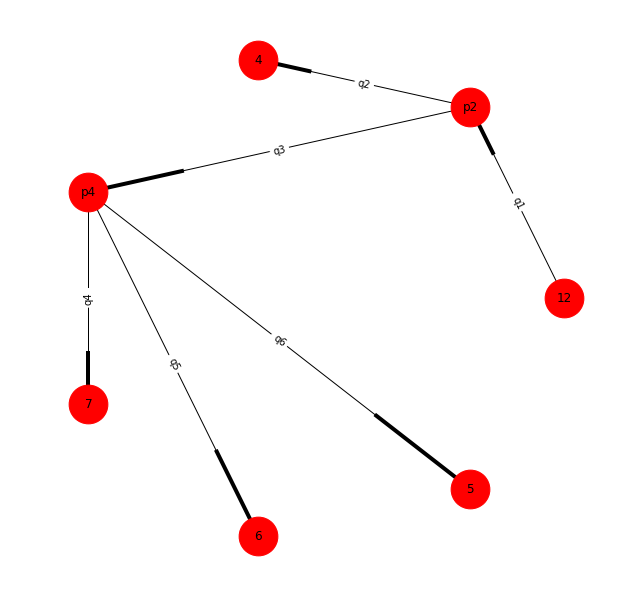

equation 1 : -p2**2 - 19*q1**2 + 144
equation 2 : p4**2 - 5*q6**2 - 25
equation 3 : p2**2 - 12*q2**2 - 16
equation 4 : p4**2 - 7*q5**2 - 36
equation 5 : p4**2 - 8*q4**2 - 49
equation 6 : p2**2 - p4**2 - 11*q3**2
equation 7 : -q1 + q2 + q3
equation 8 : -q3 + q4 + q5 + q6

Переменных : 8
[p2, p4, q1, q2, q3, q4, q5, q6]
Уравнений : 8



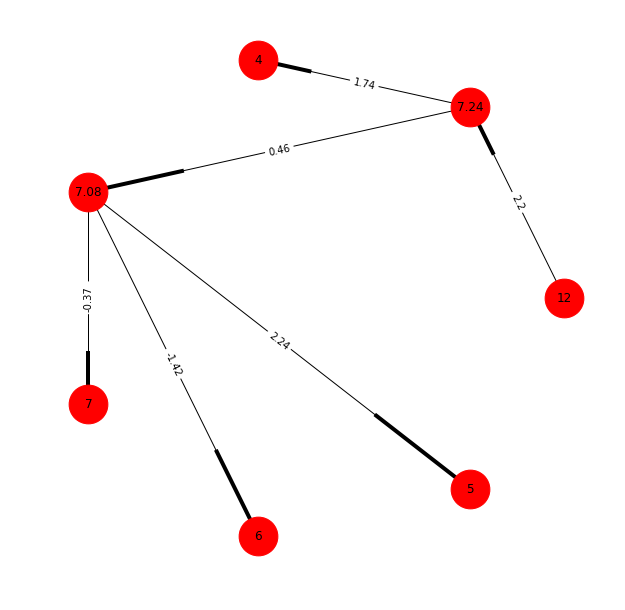

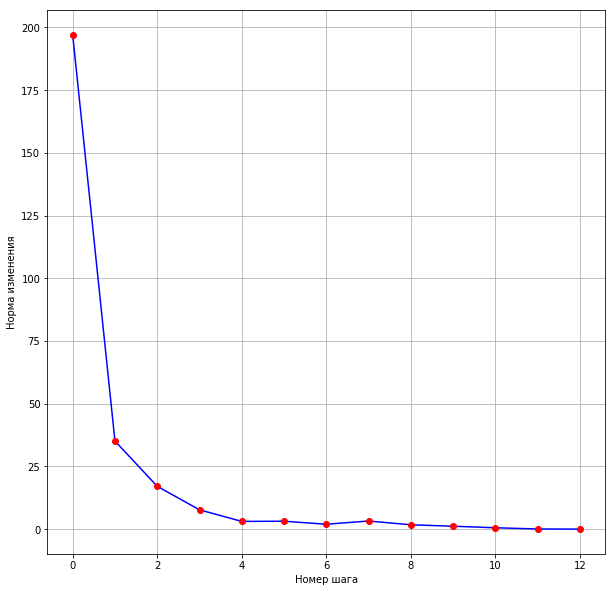


Error : 0.0


In [197]:
# #Для gpa-1.txt
values = [
    ['p2', 160],
    ['p4', 160],
    ['q1', 60],
    ['q2', 50],
    ['q3', 50],
    ['q4', 50],
    ['q5', 54],
    ['q6', 55]
]

#Для gpa-2.txt
# values = [
#     ['p2', 160],
#     ['q1', 60],
#     ['q2', 50],
#     ['q3', 50]
# ]

gpa = calc(path='gpa-1.txt', values=values)

In [198]:
values = [
    ['p1', 160],
    ['p3', 60],
    ['p4', 50]
]

In [199]:
def get_AF_AL(A=None):
    AF = sm.zeros(A.shape[0], A.shape[1])
    AL = sm.zeros(A.shape[0], A.shape[1])

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            val = int(A[i, j])
            if val == 1:
                AF[i, j] = 1
            elif val == -1:
                AL[i, j] = 1

    AF_T = sm.Matrix(AF.T)
    AL_T = sm.Matrix(AL.T)
    
    return (AF, AL)

In [200]:
def phi(ps, pf, D, L):
    return (ps ** 2 - pf ** 2)

In [223]:
def get_edge_index(gr=None, edge=()):
    return gr.edges().index(edge)

In [224]:
def replace_cols(A=None, i=0, j=0):
    shape = A.shape
    
    A_copy = deepcopy(A)
    
    rows = shape[0]
    cols = shape[1]
    
    if i < cols and j < cols:
        A_copy[:, i] = A[:, j]
        A_copy[:, j] = A[:, i]
        
        return A_copy

In [225]:
def replace_rows(A=None, i=0, j=0):
    shape = A.shape
    
    A_copy = deepcopy(A)
    
    rows = shape[0]
    cols = shape[1]
    
    print(shape, i, j)
    
    if i < rows and j < rows:
        A_copy[j, :] = A[i, :]
        A_copy[i, :] = A[j, :]
        
        return A_copy

In [230]:
def get_all_matrix(gpa=None, phi=None):
    
    A = nx.incidence_matrix(G=gpa, oriented=True).todense()
    
    P = [ gpa.node[node]['var'] for node in gpa.nodes() ]
    P = sm.Matrix(P)
    
    known_nodes = [ node for node in gpa.nodes() if gpa.node[node]['known']]
    unknown_nodes = [ node for node in gpa.nodes() if not gpa.node[node]['known']]

    known_edges = [ get_edge_index(gr=gpa, edge=edge) for edge in gpa.edges() if gpa.edge[edge[0]][edge[1]]['known']]
    unknown_edges = [ get_edge_index(gr=gpa, edge=edge) for edge in gpa.edges() if not gpa.edge[edge[0]][edge[1]]['known']]
    
    knowledges = {
        'nodes' : {
            'known' : known_nodes,
            'unknown' : unknown_nodes,
        },
        'edges' : {
            'known' : known_edges,
            'unknown' : unknown_edges
        }
    }
    
    eq = []
    
    A_s = get_AF_AL(A=A)
    
    AF_T = sm.Matrix(A_s[0].T)
    AL_T = sm.Matrix(A_s[1].T)
    
    PF = AF_T * P
    PL = AL_T * P

    for pf, ps in zip(PF, PL):
        eq.append(phi(ps, pf, 1, 1))
        
    X = sm.Matrix(eq)
    
    d_F_i = []
    d_L_i = []

    diff_vars = []
    for edge_index, eq in zip(gpa.edges(), X):
        node_s = gpa.node[edge_index[0]]['var']
        node_f = gpa.node[edge_index[1]]['var']
        
        eq_s = sm.diff(eq, node_s)
        eq_f = -sm.diff(eq, node_f)
        
        d_F_i.append(eq_s)
        d_L_i.append(eq_f)
    
    d_F_i = sm.diag(*d_F_i)
    d_L_i = sm.diag(*d_L_i)
    
    return (A, X, (AF_T, AL_T), (d_F_i, d_L_i), P, knowledges)

In [231]:
gpa, syms = read_graph(path='gpa-2.txt')
res = get_all_matrix(gpa=gpa, phi=phi)

In [232]:
A = res[0]
X = res[1]
AF_T = res[2][0]
AL_T = res[2][1]
d_F = res[3][0]
d_L = res[3][1]
P = res[4]

In [233]:
dX = (d_F * AF_T + d_L * AL_T) * P
dQ = A * dX